In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language processing
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Print out all of the other available texts in gutenberg
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [3]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
brown = gutenberg.raw('chesterton-brown.txt')
thursday = gutenberg.raw('chesterton-thursday.txt')

# The Chapter indicator is idiosyncratic
brown = re.sub(r'Chapter \d+', '', brown)
thursday = re.sub(r'CHAPTER .*', '', thursday)
    
brown = text_cleaner(brown)
thursday = text_cleaner(thursday)

In [4]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
brown_doc = nlp(brown)

In [5]:
thursday_doc = nlp(thursday)

In [6]:
# Group into sentences.
brown_sents = [[sent, "Hamlet"] for sent in brown_doc.sents]
thursday_sents = [[sent, "Macbeth"] for sent in thursday_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(brown_sents + thursday_sents)
sentences.head()

,0,1
0,(I.),Hamlet
1,"(The, Absence, of, Mr, Glass, THE, consulting,...",Hamlet
2,"(In, such, a, place, the, sea, had, something,...",Hamlet
3,"(It, must, not, be, supposed, that, Dr, Hood, ...",Hamlet
4,"(These, things, were, there, ,, in, their, pla...",Hamlet


# Bag of words

In [7]:
# Utility function to create a list of the 200 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(200)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Modeling with bag of words

In [8]:
# Set up the bags.
brownwords = bag_of_words(brown_doc)
thursdaywords = bag_of_words(thursday_doc)

# Combine bags to create a set of unique words.
common_words = set(brownwords + thursdaywords)

In [9]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000


,feel,figure,muscari,new,step,anarchist,human,begin,ratcliffe,spring,...,enemy,remember,road,street,cab,wrong,come,time,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,(I.),Hamlet
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(The, Absence, of, Mr, Glass, THE, consulting,...",Hamlet
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(In, such, a, place, the, sea, had, something,...",Hamlet
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(It, must, not, be, supposed, that, Dr, Hood, ...",Hamlet
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(These, things, were, there, ,, in, their, pla...",Hamlet


### Random Forest

In [10]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.936618089289845

Test set score: 0.6944155393687131


### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(4323, 272) (4323,)
Training set score: 0.761970853573907

Test set score: 0.719389524800555


# Tf-idf

In [12]:
hamlet = gutenberg.paras('chesterton-brown.txt')

#processing
hamlet_paras=[]
for paragraph in hamlet:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    hamlet_paras.append(' '.join(para))

print(hamlet_paras[0:4])

['[ The Wisdom of Father Brown by G . K . Chesterton 1914 ]', 'I .', 'THE consulting - rooms of Dr Orion Hood , the eminent criminologist and specialist in certain moral disorders , lay along the sea - front at Scarborough , in a series of very large and well - lighted french windows , which showed the North Sea like one endless outer wall of blue - green marble .', "Dr Hood paced the length of his string of apartments , bounded  as the boys ' geographies say  on the east by the North Sea and on the west by the serried ranks of his sociological and criminologist library ."]


In [13]:
X = sentences[0].map(lambda x: text_cleaner(str(x)))
X.head()

0                                                   I.
1    The Absence of Mr Glass THE consulting-rooms o...
2    In such a place the sea had something of the m...
3    It must not be supposed that Dr Hood's apartme...
4    These things were there, in their place; but o...
Name: 0, dtype: object

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.4, random_state=0)


#Removes all zeros from the matrix
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 5361
Original sentence: Luxury was there: there stood upon a special table eight or ten boxes of the best cigars; but they were built upon a plan so that the strongest were always nearest the wall and the mildest nearest the window.
Tf_idf vector: {'saffron': 0.4021302976978583, 'remember': 0.33696011208924276, 'park': 0.3482274417177942, 'poet': 0.3301503198303272, 'second': 0.32888613329883737, 'appearance': 0.3700112365829785, 'marked': 0.41291142085244364, 'place': 0.28092218912100986}


In [15]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 5361 to 800.
svd= TruncatedSVD(800)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 64.85165986841241
Component 0:
0
" he said.                                      0.76653
"I do," said the other "martyrs.                0.76653
"What do you do, then?" he said.                0.76653
he said.                                        0.76653
"I have the keys," he said.                     0.76653
he said.                                        0.76653
"We were three," he said.                       0.76653
" she said.                                     0.76653
"No," said Syme. "                              0.71335
"Ah, it was what he said!" said Syme darkly.    0.54861
Name: 0, dtype: float64
Component 1:
0
" she said.                                                                     0.522317
"I do," said the other "martyrs.                                                0.522317
he said.                                                                        0.522317
"I have the keys," he said.                             

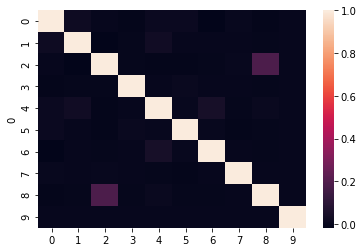

Key:
0 It was security, eternity I can't convey it...
1 "I think them equally valueless," replied Brown. "
2 Rifles were ranked so far away that an enemy could not slink into the town by any detour; therefore it was vain to return to the city by any remote course.
3 But, for the last time, where are your goloshes?
4 "Comrade Gregory," said the chairman after a painful pause, "this is really not quite dignified.
5 There are others who may remember it because it marked the first appearance in the place of the second poet of Saffron Park.
6 Then he said, with a clearly modulated and rather mincing articulation: `Would it discommode you to contribute elsewhere a coin with a somewhat different superscription?' "
7 I am going to pull that meeting's great ugly, mahogany-coloured nose."
8 On his right was a little wood; far away to his left lay the long curve of the railway line, which he was, so to speak, guarding from the Marquis, whose goal and escape it was.
9 He's packing up, I tell you."

In [16]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])